In [113]:
from data_gen import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [114]:
# Simulation Parameters

# General
np.random.seed(42)
years = 5
T = range(365*years) 

# Seasonality 
yearly_P = 365 # yearly period
weekly_P = 7 # weekly period
beta_y_sigma = 1 # variance of yearly seasonality
beta_w_sigma = 0.3 # variance of weekly seasonality

# Growth
tau = 0.0003 # laplace prior
k = 0.0005 # base-rate for growth, expressed in growth per day
m = len(T)/2 # Offset parameter
C_t = 100 # Note this is for all t, but in paper can be time-varying!
changepoint_freq = 180 # How often do changepoints occur?

# Holidays
nu = 5 # the variance of the normal distribution on holiday-effect.
kappa_1_mean = 0 # the mean of the normal distribution 1.
kappa_2_mean = 0 # the mean of the normal distribution 2.
kappa_3_mean = 0 # the mean of the normal distribution 3.
kappa_4_mean = 0 # the mean of the normal distribution 4.

# Noise
noise_sigma = 0.00001

**Seasonality $s(t)$**

In [115]:
Seasonal_y = gen_fourier(T, yearly_P, 10, sigma = beta_y_sigma)
Seasonal_w = gen_fourier(T, weekly_P, 3, sigma = beta_w_sigma)

**Growth $g(t)$**

In [116]:
s = np.array(range(0, len(T), changepoint_freq))
a = [find_a_t(s, t = t) for t in T]
delta = gen_delta(T, 
                  changepoint_freq, 
                  tau)

In [117]:
# define a dictionary to store results
memo = {}

def find_gamma_j(j, k, delta, m):
    
    # compute gamma_l using memoization
    gamma_l = 0
    for l in range(j):
        if l in memo:
            gamma_l += memo[l]
        else:
            memo[l] = find_gamma_j(l, k, delta, m)
            gamma_l += memo[l]

    # compute delta_l using memoization
    delta_l = 0
    for l in range(j):
        if l in memo:
            delta_l += delta[l]
        else:
            delta_l += delta[l]
    
    # compute first term
    first_term = s[j] - m - gamma_l
    
    # compute second term
    second_term = (1 - (k + delta_l) / (k + delta_l + delta[j]))
    
    # compute result and store in memo
    result = first_term * second_term
    memo[j] = result
    
    return result

# initialize memo with initial values
memo[0] = find_gamma_j(0, k, delta, m=m)

# compute gamma for all j values
gamma = [memo[j] if j in memo else find_gamma_j(j, k, delta, m=m) for j in range(len(s))]


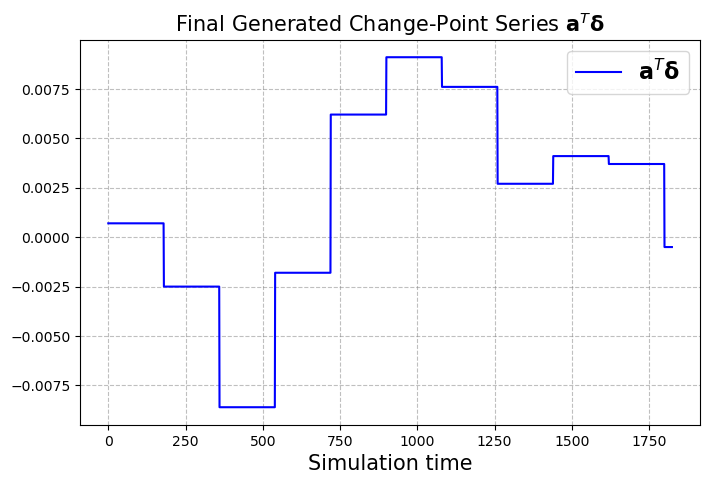

In [118]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 8, 5
# Assuming that 'delta' is a list or array of values
delta_plot = np.dot(a, delta)

# Create the plot
plt.plot(delta_plot*10, color='blue', label = r"$\mathbf{a}^T\mathbf{\delta}$")
plt.grid(True, linestyle='--', color='gray', alpha=0.5)
# Add a title
plt.title(r'Final Generated Change-Point Series $\mathbf{a}^T\mathbf{\delta}$', fontsize = 15)
plt.xlabel("Simulation time", fontsize = 15)
plt.legend(fontsize = 16)
# Show the plot
plt.show()


In [119]:
g_T = []

for t in T:
    num = C_t
    denom = 1+np.exp(-1*(k+np.dot(a[t], delta))*(t - (m+np.dot(a[t], gamma))))

    g_t = num/denom

    g_T.append(g_t)

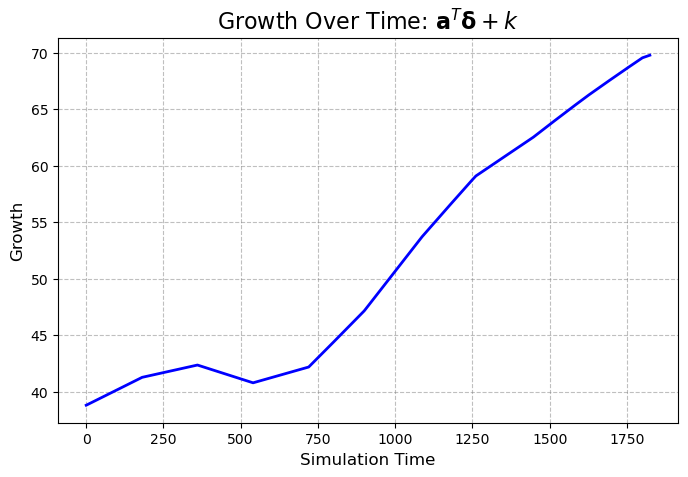

In [120]:
# create a new figure and set the size
fig, ax = plt.subplots(figsize=(8, 5))

# plot the growth rate
ax.plot(pd.DataFrame(g_T), color='blue', linewidth=2)

# set the x and y axis labels
ax.set_xlabel('Simulation Time', fontsize=12)
ax.set_ylabel('Growth', fontsize=12)

# set the title of the plot
ax.set_title(r'Growth Over Time: $\mathbf{a}^T\mathbf{\delta} + k$', fontsize=16)

# add a grid to the plot
ax.grid(True, linestyle='--', color='gray', alpha=0.5)

# remove the top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# show the plot
plt.show()



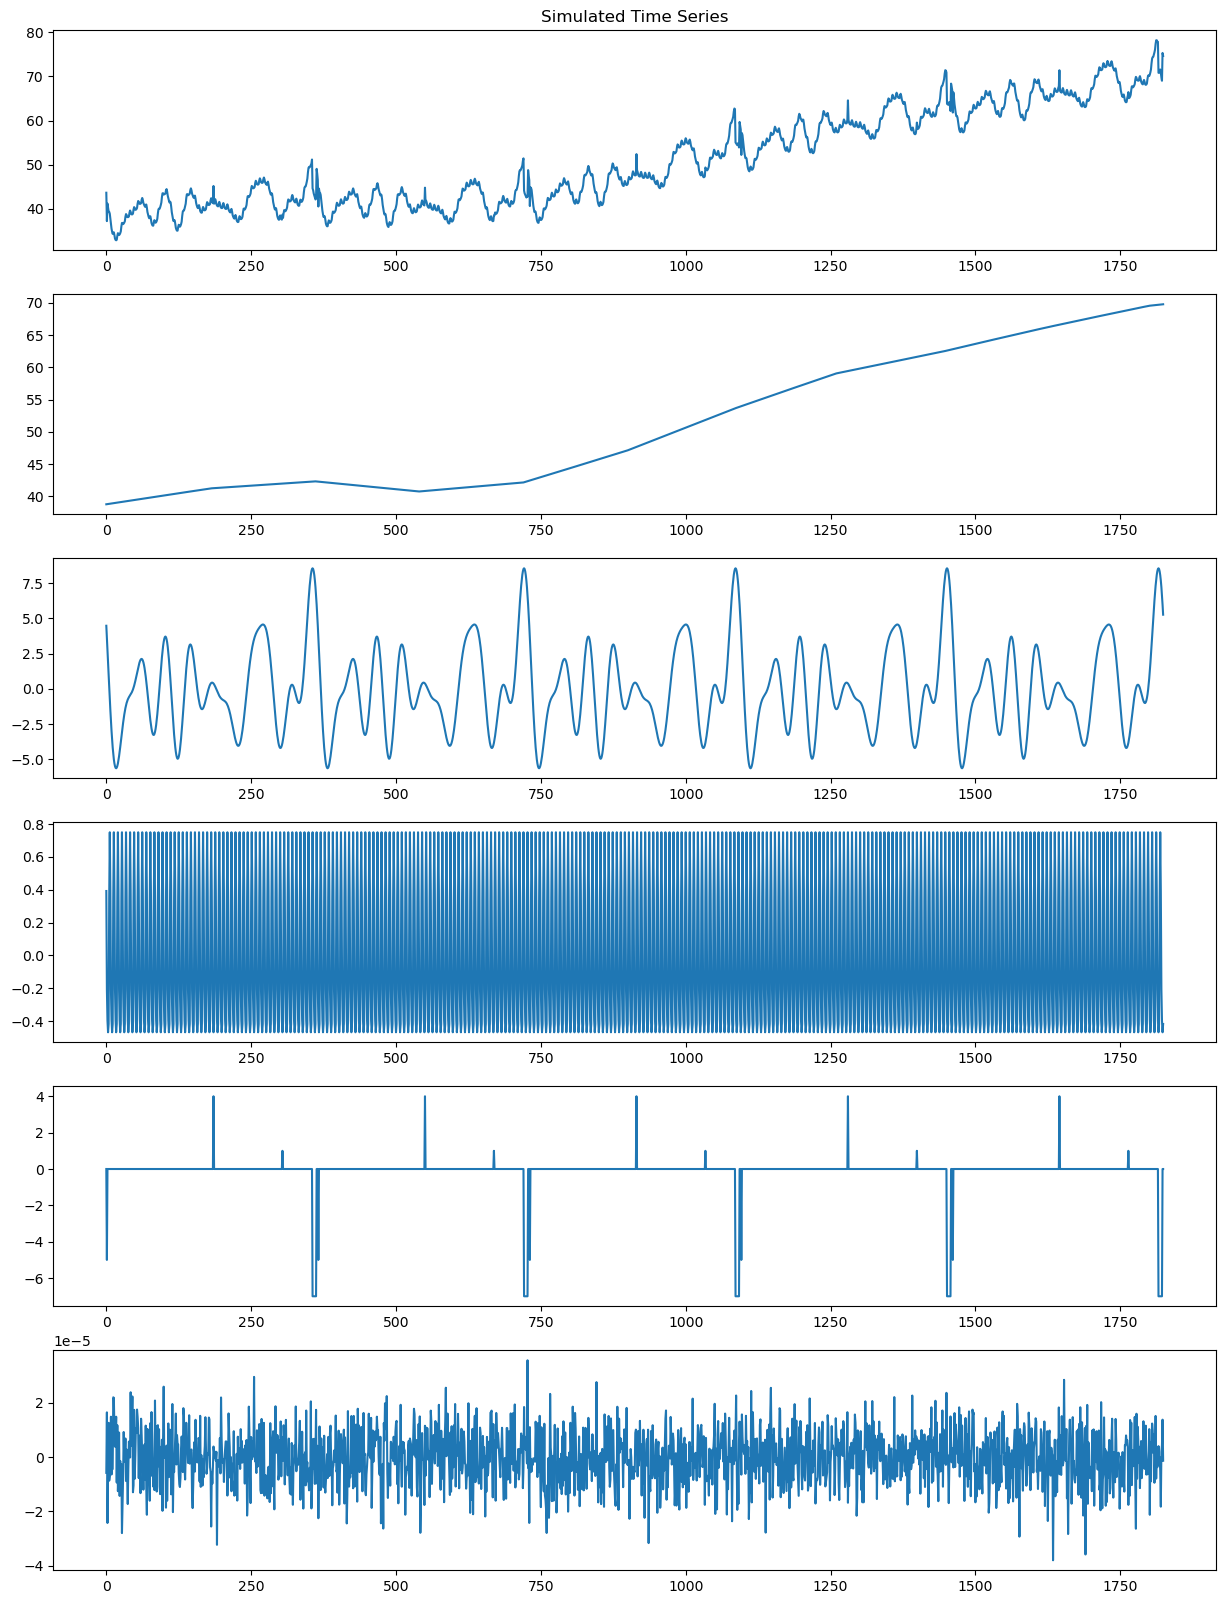

In [121]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 6)
fig.set_size_inches(15, 20)
# Set random seed for reproducibility
np.random.seed(123)

# Define time range and step
t = np.arange(0, 365*years, 1)  # 1 year, 1 day step

# Define trend, seasonality, and holiday components
g = g_T  # Linear trend
s = Seasonal_y + Seasonal_w  # Monthly and yearly seasonality
h = np.zeros_like(t)  # No holidays for now

hol_1_bump =  np.random.normal(kappa_1_mean, nu)
hol_2_bump = np.random.normal(kappa_2_mean, nu)
hol_3_bump = np.random.normal(kappa_3_mean, nu)
hol_4_bump = np.random.normal(kappa_4_mean, nu)

NYD = 1
CHRISTMAS = np.arange(356, 363)
FOURTH_OF_JULY = 185
HALLOWEEN = 304

h[NYD] = hol_1_bump
h[FOURTH_OF_JULY] = hol_2_bump
h[HALLOWEEN] = hol_3_bump
h[356:363] = hol_4_bump

for year in range(years):

    buffer = year*365 

    h[NYD + buffer] = hol_1_bump # New Year's Day
    h[FOURTH_OF_JULY + buffer] = hol_2_bump # 4 of July
    h[HALLOWEEN + buffer] = hol_3_bump # Halloween
    h[356 + buffer:363 + buffer] = hol_4_bump # Christmas

# Simulate noise
epsilon = np.random.normal(loc=0, scale=noise_sigma, size=len(t))

# Generate time series
y = g + s + h + epsilon

# Plot the time series
ax[0].plot(t, y)
ax[0].set_title('Simulated Time Series')

# Plot the time series
ax[1].plot(t, g)

ax[2].plot(t, Seasonal_y)

ax[3].plot(t, Seasonal_w)

# Plot the time series
ax[4].plot(t, h)

# Plot the time series
ax[5].plot(t, epsilon)


/var/folders/q6/czkds0m930qfg8g6_k7km9cm0000gp/T/ipykernel_84278/4075802889.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(["", 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


Text(0, 0.5, 'Value')

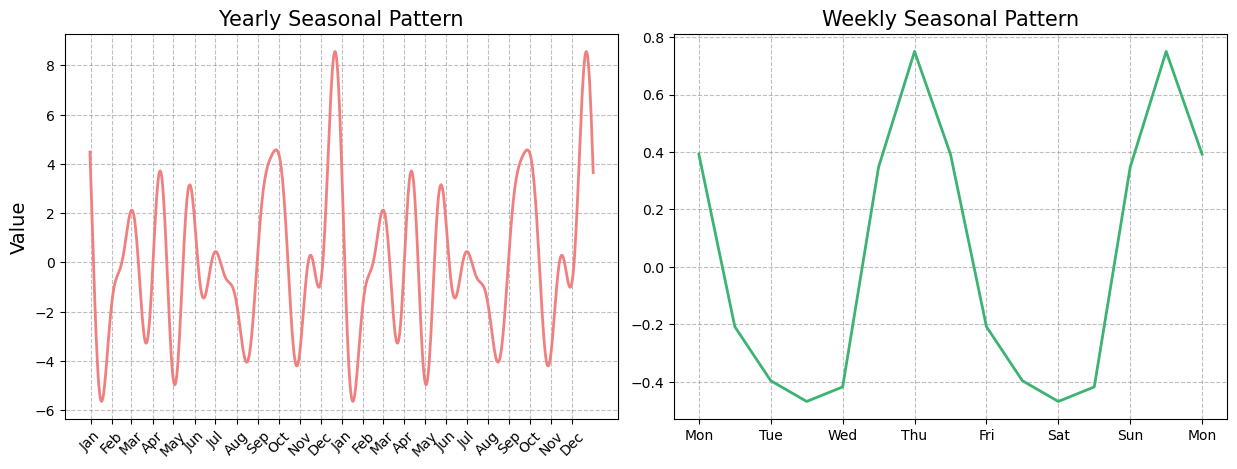

In [122]:
fig, ax = plt.subplots(ncols = 2, gridspec_kw = {'wspace': 0.1})

fig.set_size_inches(15, 5)
ax[0].plot(t[:(365+1)*2], Seasonal_y[:(365+1)*2], color = 'lightcoral', linewidth = 2)

ax[1].plot(t[:15], Seasonal_w[:15], color = 'mediumseagreen', linewidth = 2)

month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_starts_2 = [335+30+i for i in month_starts]

ax[0].set_xticks(month_starts + month_starts_2)
ax[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
                       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation = 45)
ax[1].set_xticklabels(["", 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax[0].grid(True, linestyle='--', color='gray', alpha=0.5)
ax[1].grid(True, linestyle='--', color='gray', alpha=0.5)

ax[0].set_title("Yearly Seasonal Pattern", fontsize = 15)
ax[1].set_title("Weekly Seasonal Pattern", fontsize = 15)

ax[0].set_ylabel("Value", fontsize = 14)


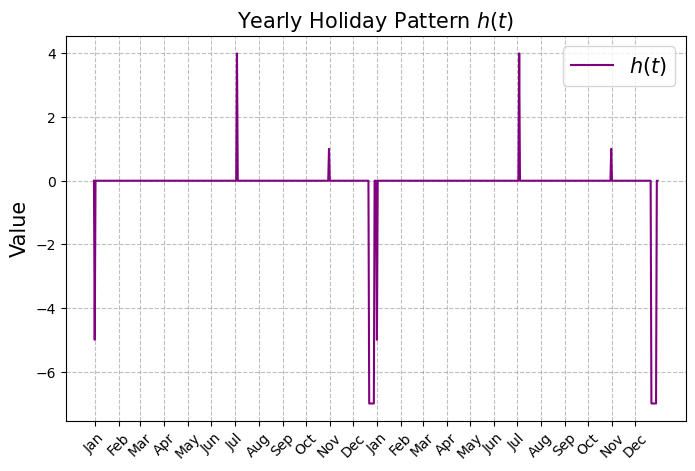

In [123]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
# Plot the time series
ax.plot(t[0:365*2], h[0:365*2], color = 'purple', label = r"$h(t)$")
month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_starts_2 = [335+30+i for i in month_starts]
ax.set_xticks(month_starts + month_starts_2)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
                       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation = 45)

ax.set_ylabel("Value", fontsize = 15)
ax.set_title(r"Yearly Holiday Pattern $h(t)$", fontsize = 15)
ax.legend(fontsize = 15)
ax.grid(True, linestyle='--', color='gray', alpha=0.5)

22:43:47 - cmdstanpy - INFO - Chain [1] start processing
22:43:47 - cmdstanpy - INFO - Chain [1] done processing


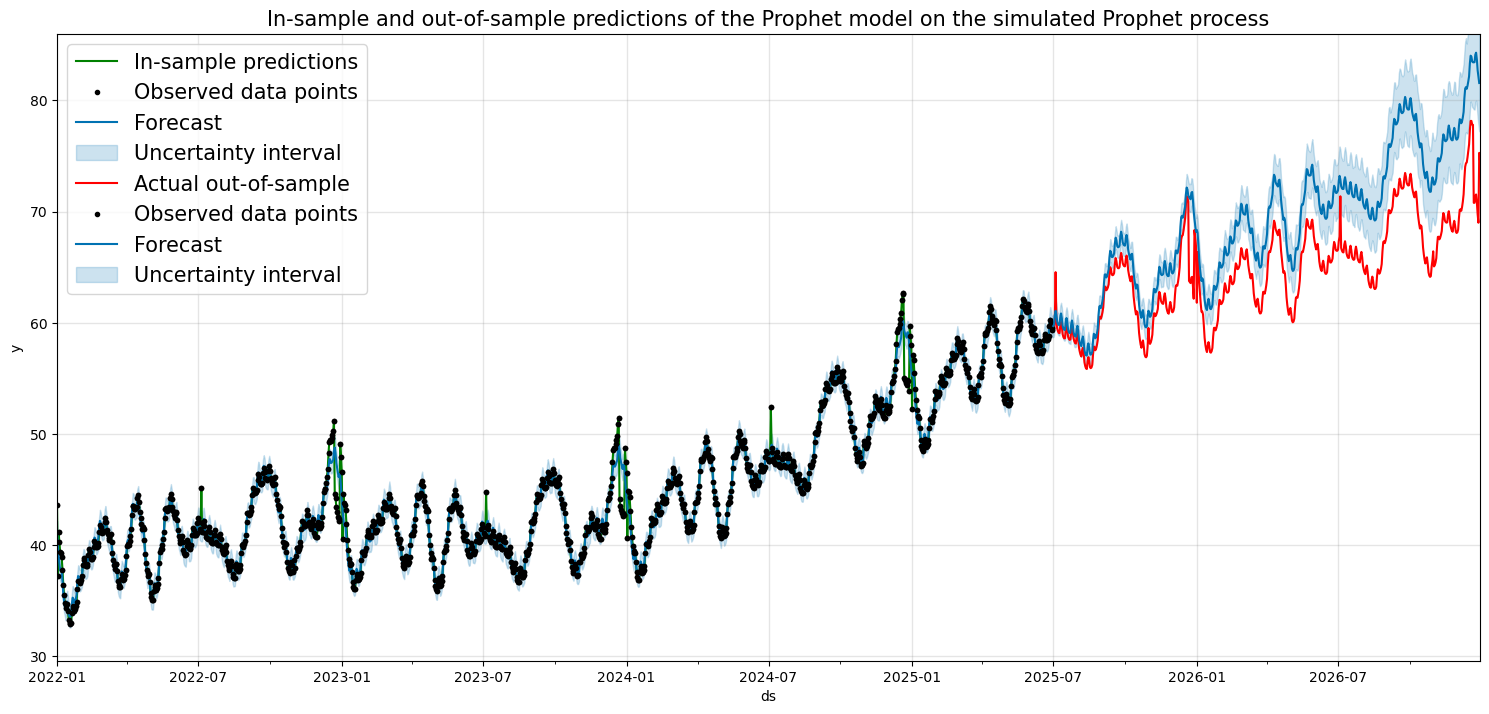

In [124]:
import pandas as pd
from prophet import Prophet

fig, ax = plt.subplots()

fig.set_size_inches(15, 7)
test_size = 0.3
train_size = 1-test_size
# Convert time series to dataframe
df = pd.DataFrame({'ds': pd.date_range(start='2022-01-01', periods=len(t), freq='D'),
                   'y': y})

train_df = df.iloc[:int(len(t)*train_size)]
test_periods = int(len(t)*test_size)

# Initialize and fit Prophet model
model = Prophet(seasonality_mode='additive',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                holidays_prior_scale=nu)
                
model.fit(train_df)

# Generate future dates for forecasting
future = model.make_future_dataframe(periods=test_periods, freq='D')

# Make predictions
forecast = model.predict(future)

df.set_index("ds", inplace=True)
train_df.set_index("ds", inplace=True)
test_df = df.iloc[-test_periods:]

# Plot the actual values and in-sample forecasts
train_df['y'].plot(ax=ax, color='green', label = 'In-sample predictions')
model.plot(forecast.iloc[:-test_periods], ax=ax, plot_cap=True)

# Plot the out-of-sample forecasts
test_df['y'].plot(ax=ax, color='red', label = 'Actual out-of-sample')
model.plot(forecast.iloc[-test_periods:], ax=ax)

ax.set_ylim(0.9*df['y'].min(), 1.1*df['y'].max())
ax.set_title("In-sample and out-of-sample predictions of the Prophet model on the simulated Prophet process", fontsize = 15)
ax.legend(fontsize = 15)
plt.show()
